<a href="https://colab.research.google.com/github/alexfok/IntroDeepLearning2022/blob/main/Assignment4_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alexander Fok 308669944

Avi Dvir 204423735

Gal Cohen 204675805

# **Assignment 4 - Variational Autoencoders**

In this assignment, we will train a model to produce new human faces with variational autoencoders (VAEs). 
Variational autoencoders let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces (as we'll do in this assignment), high-resolution digital artwork and many more tasks. These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma and Wellings [1].

In this assignment, you will build, train and analyze a VAE with the CelebA dataset. You will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the CelebA dataset.

[1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). 


# **Section 1: Variational Autoencoders**


Let us recall the structure of the variational autoencoder:

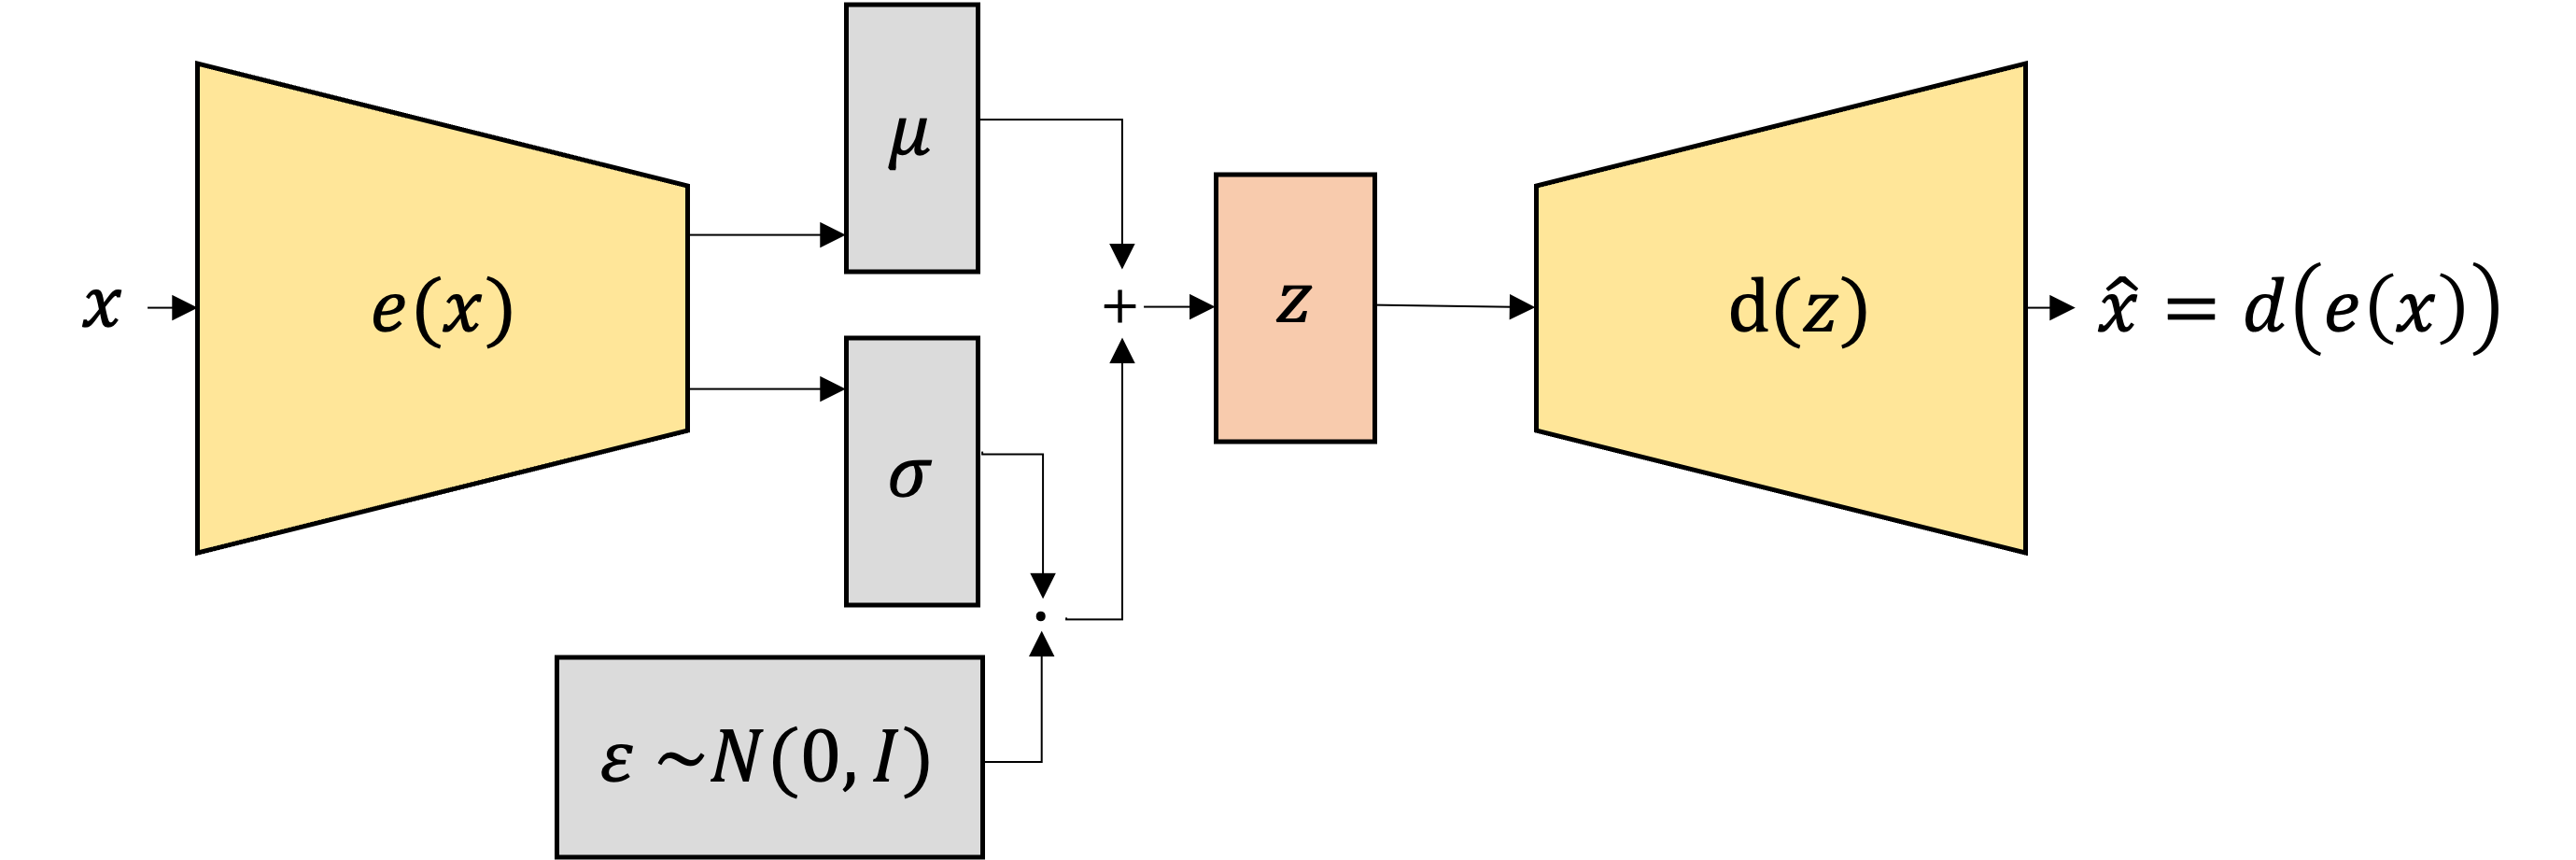

**Imports**

Before we begin, we import the needed libraries. 


You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile

%pip install wget   
import wget

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=e210696dbb770696eccf880dbc351be74ff14dfc601289e0521efbb262c4a350
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Path to save the dataset.
#PATH_TO_SAVE_MODEL = '/content/gdrive/MyDrive/' # TODO - UPDATE ME!

Define random seeds in order to reproduce your results.

In [3]:
# TO DO: Set random seeds - to your choice
torch.manual_seed(1)         # Insert any integer
torch.cuda.manual_seed(1)    # Insert any integer

## Question 1. Basic Principles (10 %)




### Part (a) -- 3%

What is the difference between deterministic autoencoder we saw in class and the variational autoencoder? 

The Difference between deterministic autoencoder to variational autoencoder: 

Autoencoder: 
- Using Generate a compressed transformation of input in latent space
-the latent variable is not regularized as in VAE
-picking a random latent variable will generate garbage output
-the latent variable has a discontinuity 
-latent variable is deterministic values 
-the latent space lacks the generative capability


Variational Autoencoder : 
-enforces condistions on the latent variable to be the unit norm
-the latent variable in the compressed form is mean and variance 
-the latent bariable is smooth and continuous
-A random value of latent variable generates meaningful output at the decoder
-the input of the decoder is stochastic and is sampled from a gaussian with mean and variance of the out of the encoder
-Regulrized latend space
-the latent space hag generative capabilities

Autoencoder
הינו רשת המאמנת לבצע הורדת מימד לדאטה, תוך אבוד מינימלי של מידע.

מאומן לייצג את הדאטה במימד נמוך, שלוקח בחשבון את המאפיינים העיקריים ולאחר מכן משחזר את התוצאה לממד המקורי. בשונה מ"האוטואנקודר" שלוקח דאטה ורק בונה לו ייצוג מממד נמוך. ה"וי אי אי" קובע התפלגות פריורית למרחב הלטנטי "זאד" למשל התפלגות נורמלית עם תוחלת 0 ומטריצת קווואריאנס. באופן הזה הלמידה דואגת לא רק להורדת הממד של הדאטה, אלא גם להתפלגות המושרית על המרחב הלטנטי. Autoencoder
חשוב להשים לב להבדל בתפקיד של ש"דקודר" בעוד שב"אוטואנקודר" הוא נועד לתהליך האימון בלבד ובפועל מה שחשוב זה הייצוג הלטנטי וב"וי אי אי" הדקודר חשוב לא פחות מאשר הייצוג הלטנטי, כיוון שהוא זה שמשמש ליצירת דאטה חדש לאחר תהליך האימון או במילים אחרות הוא הופך את המערכת למודל גנרטיבי.

VESs task is different. With VES we generate new samples that are supposed to be similar to the samples from the original input distribution.

### Part (b) -- 3%
In which manner Variational Autoencoder is trained? Explain.


Here is how the VAE model is trained: 

1.it start by encoding the input as distibution over the latent space
2.a point from the latent space is sampled from that distribution 
3. the poiint that was sampled gets decoded and the reconstruction error is computed 
4.the reconstruction error is backpropagated through the network 

the input is encoded as distribution with a bit of variace rather than a single point so that its posiible to naturally express the latent space regularision
the encoder returns the distributions which are enforced to be clost to a standart normal distribution 

the loss function is minimized made up of reconstruction term on the final layer which makes the encoding-decoding scheme as performant as possible , along with 
a regularization term ofn latent layer, which regularizes the organisation of the latent space by virtue of making the distributions returned by the encoder clost to a standart normal
distribution

נתאר את תהליך האימון.
האנקודר מאמן רשת שמקבלת דוגמאות מסט האימון ומנסה להפיק מהן פרמטרים של התלפלגות איקס|זאד הקרובים כמה שניתן לפרמטרים של ההתפלגות הפריורית זאד שכאמור נקבעה מראש.
מההתפלגות הנלמדת הזו דוגמים וקטורים לטנטיים חדשים ומעבירים אותו לדאקודר.
הדאקודר מבצע את הפעולה ההפוכה - לוקח וקטור שנדגם במרחב הלטנטי איקס|זאד ומייצר באמצעותו דוגמא חדשה שאמורה להיות דומה לדאטה המקורי.
תהליך האימון יהיה כזה שימזער את השגיאה של שני חלקי ה"וי אי אי" גם זאד|איקס שבמוצא יהיה כמה שיותר קרוב לאיקס המקורי וגם ההתפלגות איקס|זאד תהיה כמה שיותר קרובה להתפלגות הפריורית זאד.



### Part (c) -- 4%

In class we saw another generative model, known as generative adversarial network (GAN). What are the differences in terms of task objective between GANs and VAEs? Give an example for a task which a VAE is more suitable than GAN, and vice versa.

# Write your explanation here
The main difference between VAEs and GANs is their learning process.VAEs are minimizing a loss reproducing a certain
image, and can , therefore be considerd as solving a semi-supervised learning problem
GANs on the other hand are solving an unsupervised learning problem. 
the most important differance is training time for the two methods. Gans took longer time to train
therefore the use of GANS considered and proved a lot more stable
so for low-diversity datasets like MNIST for example both methods will give sufficiently realistic images.

so if we want Result in less time but with decreased image quality its VAE
longer train time and shaper results - GANS

example for VAE is more suitable then GAN 
CelebA Data set 
the GAN produces sharper images then VAE neverthe less, the faces produced by the VAE look more natural appearance
example for GAN is more suitable then VAE
CIFAR-10 Data set
the images of VAE will be blurry and unrecognized compared to GAN that generates images with sharper images


גאנס בשונה מוי אי אי בגישה זו לא מנסים לשערך התפלגות של דאטה בצורה מפורשת אלא יוצרים דאטה באופן אחר.
הרעיון הוא לאמן שתי רשתות במקביל, רשת אחת שלומדת לייצר דוגמאות ורשת שניה שלומדת להבחין בין הדוגמא האמיתית מסט האימון לבין תמונה סינתטית שנוצרה על ידי הרשת הראשונה.
הרשת הראשונה מאומנת ליצור דוגמאות שיגרמו לרשת השנייה לחשוב שהן אמיתיות, בזמן שהמטרה של הרשת השנייה היא לא לתת לרשת הראשונה לבלבל אותה. באופן הזה הרשת הראשונה מהווה למעשה מודל גנרטיבי, שלאחר שלב האימון היא מסוגלת לייצר דאטה סינתטי שלא ניתן להבין בינו לבין דאטה אמיתי.


## Question 2. Data (15 %)

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

Here, you will download the dataset to the Google Colab disk. It is highly recommended not to download the dataset to your own Google Drive account since it is time consuming.

In [4]:
data_path = "datasets" ## TO DO -- UPDATE ME!

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_path}/celeba"
if not os.path.exists(f"{dataset_folder}"):
  os.makedirs(dataset_folder, exist_ok=True)

  for file in file_list:
      url = f"{base_url}/{file}"
      if not os.path.exists(f"{dataset_folder}/{file}"):
          wget.download(url, f"{dataset_folder}/{file}")

  with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
      ziphandler.extractall(dataset_folder)

In [5]:
!ls -lah $dataset_folder

total 1.4G
drwxr-xr-x 3 root root 4.0K Jan 11 22:22 .
drwxr-xr-x 3 root root 4.0K Jan 11 22:21 ..
-rw-r--r-- 1 root root 3.3M Jan 11 22:22 identity_CelebA.txt
drwxr-xr-x 2 root root 5.7M Jan 11 22:22 img_align_celeba
-rw-r--r-- 1 root root 1.4G Jan 11 22:22 img_align_celeba.zip
-rw-r--r-- 1 root root  26M Jan 11 22:22 list_attr_celeba.txt
-rw-r--r-- 1 root root 5.9M Jan 11 22:22 list_bbox_celeba.txt
-rw-r--r-- 1 root root 2.8M Jan 11 22:22 list_eval_partition.txt
-rw-r--r-- 1 root root  12M Jan 11 22:22 list_landmarks_align_celeba.txt


### Part (a) -- 5%

Apply transformations:

The data is given as PIL (Python Imageing Library) images. Since we are working with PyTorch, we wish to apply transformations to the data in order to process it properly.

Here you should apply transformations to the data. There are many kinds of transformations which can be found here: https://pytorch.org/vision/stable/transforms.html. Note that transformations can be chained together using Compose method.

Think which transformations can be suitable for this task and apply it in the form of: 

trfm = transforms.Compose([transforms.transform1(),transforms.transform2(),...])

We recommend to consider:
- transforms.ToTensor()
- transforms.Resize()

In [6]:
norm_mean = 0.5 
norm_std = 0.5 
#image_h, image_w = (224, 224)
image_h, image_w = (64, 64)
image_size = (64, 64)

#trfm = transforms.Compose([transforms.ToTensor(), transforms.PILToTensor(), transforms.Normalize((norm_mean,), (norm_std,))]) # You can add additional transformations which you think could be fit to the data.
trfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((norm_mean,), (norm_std,))]) # You can add additional transformations which you think could be fit to the data.
#trfm = transforms.Compose([transforms.Resize((image_h, image_w)), transforms.ToTensor()]) # You can add additional transformations which you think could be fit to the data.
trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()]) # You can add additional transformations which you think could be fit to the data.
# transforms.PILToTensor ??
# Normalize(mean, std[, inplace])
# transforms.Resize((224, 224)),
training_data = datasets.CelebA(root=data_path, split='train', download=False, transform=trfm) #load the dataset (without download it directly) from our root directory on google drive disk. 
test_data = datasets.CelebA(root=data_path, split='test', download=False, transform=trfm)


### Part (b) -- 5%

In order to get in touch with the dataset, and to see what we are dealing with (which is always recommended), we wish to visualize some data samples from the CelebA dataset.

Write a function: show():

INPUT: Python list of length 32 where each element is an image, randomly selected from the training data.

OUTOUT: Showing a 8X4 grid of images.

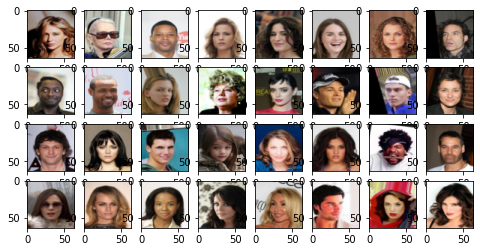

In [7]:
def show(imgs):
    # your code goes here:
  plt.figure(figsize=(8, 4))
  for i, item in enumerate(imgs):
      if i >= 32:
#        print('indexes error')
        break
      plt.subplot(4, 8, i+1)
      img = item.numpy().transpose((1, 2, 0))
      plt.imshow(img)
#      plt.imshow(item[0].squeeze().numpy())

  return None

xs = []
for i in range(32):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, _ = training_data[sample_idx]
  xs.append(img)
show(xs)



### Part (c) -- 5%

Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

img.shape: (64, 64, 3)


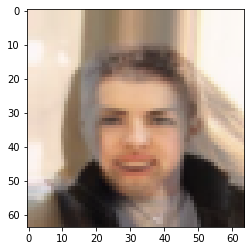

In [8]:
# Your code goes here
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img1, _ = training_data[sample_idx]
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img2, _ = training_data[sample_idx]
alpha = 0.5

img3 = alpha*img1 + (1-alpha)*img2
img = img3.numpy().transpose((1, 2, 0))
plt.figure(clear=True)
plt.imshow(img)
print(f'img.shape: {img.shape}')



# Your explanation goes here:
It doesn't make sence to extrapolate images in image domain.

## Question 3. VAE Foundations (15 %)


Let us start by recalling the analytical derivation of the VAE.


The simplest version of VAE is comprised of an encoder-decoder architecture.
The *encoder* is a neural network which its input is a datapoint $x$, its output is a hidden representation $z$, and it has weights and biases $\theta$. We denote the encoder's mapping by $P_{\theta}(z|x)$. The *decoder* is another neural network which its input is the data sample $z$, its output is the reconstructed input $x$, and its parameters $\phi$. Hence, we denote the decoder's mapping by $P_{\phi}(x|z)$.

The goal is to determine a posterior distribution $P_{\theta}(z|x)$ of a latent variable $z$ given some data evidence $x$. However, determining this posterior distribution is typically computationally intractable, because according to Bayes:

$(1)$ $P(z|x) = \frac{P(x|z)P(z)}{P(x)}$

The term $P(x)$ is called the evidence, and we can calculate it by marginalization on the latent variable:

$P(x) = \int_{z}P(x|z)P(z)dz$

Unfortunately, this term is intractable because it requires computation of the integral over the entire latent space $z$. To bypass this intractability problem we approximate the posterior distribution with some other distribution $q(z|x_i)$. This approximation is made by the KL-divergence:

$(2)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = \int_{z}q(z|x_i)\cdot\log\big(\frac{q(z|x_i)}{P(z|x_i)}\big)dz = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(z|x_i)}{q(z|x_i)}\big)dz \geq 0$

Applying Bayes’ theorem to the above equation yields,

$(3)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)P(x_i)}\big)dz \geq 0$

This can be broken down using laws of logarithms, yielding,

$(4)$ $-\int_{z}q(z|x_i)\cdot\big[\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)-\log(P(x_i))\big]dz \geq 0$

Distributing the integrand then yields,

$(5)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\int_{z}q(z|x_i)\log(P(x_i))dz \geq 0$

In the above, we note that $log(P(x))$ is a constant and can therefore be pulled out of the second integral above, yielding,

$(6)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i))\int_{z}q(z|x_i)dz \geq 0$

And since $q(z|x_i)$ is a probability distribution it integrates to 1 in the above equation, yielding,

$(7)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i)) \geq 0$

Then carrying the integral over to the other side of the inequality, we get,

$(8)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz$

<!-- Applying rules of logarithms, we get,

$(9)$ $\log(P(x)) \geq \int_{z}q(z|x)\cdot\big[\log\big(P(x|z)\big)+\log\big(P(z)\big)-\log\big(q(z|x)\big)\big]dz$

Recognizing the right hand side of the above inequality as Expectation, we write,

$(10)$ $\log(P(x)) \geq E_{~q(z|x)}\big[\log\big(P(x,z)\big)-\log\big(q(z|x)\big)\big]dz$ -->

From Equation $(8)$ it follows that:

$(9)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(z)}{q(z|x_i)}\big)dz + \int_{z}q(z|x_i)\cdot\log\big(P(x_i|z)\big)dz$

Which is equivalent to:

$(10)$ $\log(P(x_i)) \geq -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$



The right hand side of the above equation is the Evidence Lower BOund (ELBO). Its bounds $\log(P(x))$ which is the term we seek to maximize. Therefore, maximizing the ELBO maximizes the log probability of our data. 


### Part (a) -- 5%
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



# Write your explanation here
Evidence lower bound is comprised of 2 terms : 

1.Evidence logp(x:0)
2.Kullback-Leibler divergance between P(Z|x;0) and q(z)

1. if we have chosen the right model p and 0 then we would expect that the marginal probablity of our observed data X would be high
because of logp(X;0) indicated that we on the right track with the model P and parameter 0 
2. intuitively this measures the how much a given arbitrary distribution is away from the true distribution. 
If two distributions perfectly match, D_{KL} (p||q) = 0 otherwise it can take values between 0 and ∞. Lower the KL divergence value
the better we have matched the true distribution with our approximation



### Part (b) -- 10%

 As we saw in class, in traditional variational autoencoder we assume:

$P(z)$ ~ $N(\mu_p,\sigma_{p}^2) = \frac{1}{\sqrt{2\pi\sigma_{p}^2}}\exp\big(-\frac{(z-\mu_p)^2}{2\sigma_{p}^2}\big)$

and

$q(z|x)$ ~ $N(\mu_q,\sigma_{q}^2) = \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)$

Assume $\mu_p = 0$ and $\sigma_{p}^2 = 1$. Show that:

$ -D_{KL}\big(q(z|x_i)||P(z)\big) = \frac{1}{2}\big[1+\log(\sigma_{q}^2)-\sigma_{q}^2-\mu_q^2\big]$ 

 

To calculate the KL divergence between the two distributions q(z|xi) and P(z), we can use the formula:

DKL(q(z|xi)||P(z)) = ∫ q(z|xi) log(q(z|xi)) / P(z) dz

Given the assumption that P(z) ~ N(0,1) and q(z|xi) ~ N(μq,σ2q), we can substitute these distributions into the equation above:

DKL(q(z|xi)||P(z)) = ∫ N(z; μq,σ2q) log(N(z; μq,σ2q)) / N(z;0,1) dz

Using the properties of the normal distribution and integrating, we can simplify the equation above:

DKL(q(z|xi)||P(z)) = 1/2 * (log(σ2q) + 1 - μ2q - σ2q)

Since we are looking for -DKL(q(z|xi)||P(z)), we can take negative of the above equation

-DKL(q(z|xi)||P(z)) = -1/2 * (log(σ2q) + 1 - μ2q - σ2q)

then ,

-DKL(q(z|xi)||P(z)) =1/2 * [-log(σ2q) - 1 + μ2q + σ2q]

which is equivalent to

-DKL(q(z|xi)||P(z)) =1/2 * [1 + log(σ2q) -σ2q - μ2q ]

**WRITE YOUR SOLUTIUON HERE**. (You can also upload your solution as an image.)





**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## Question 4. VAE Implementation (25 %)

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




***Transposed Convolution with Stride = 1***

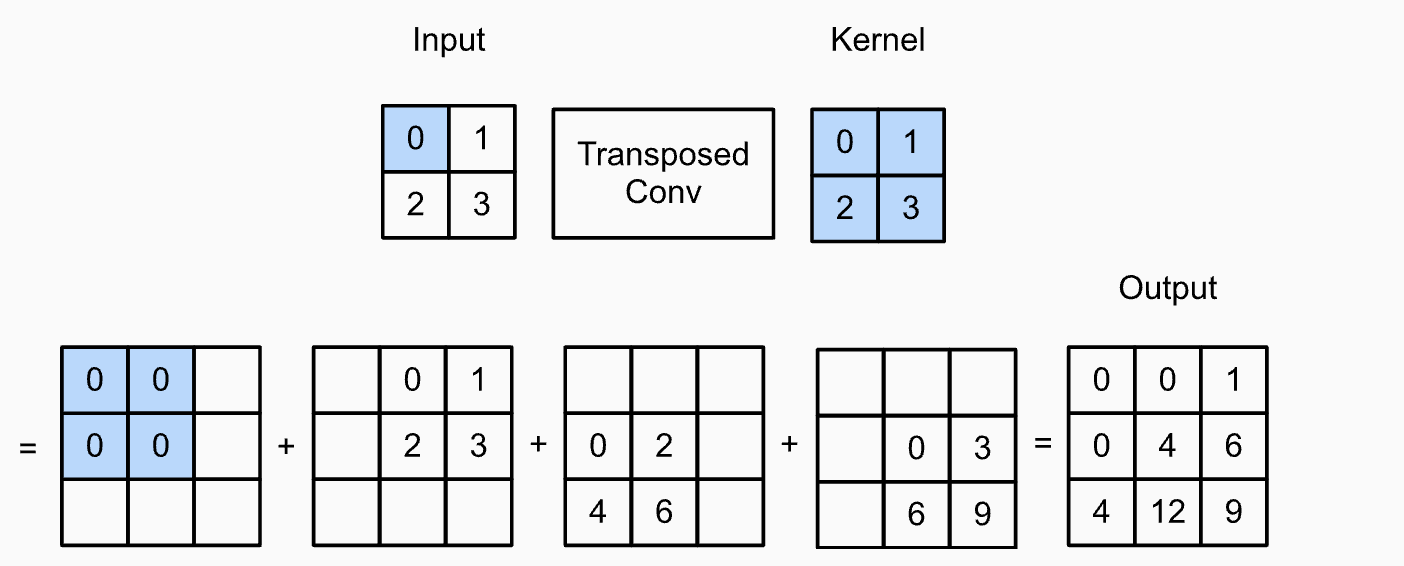

***Transposed Convolution with Stride = 2***
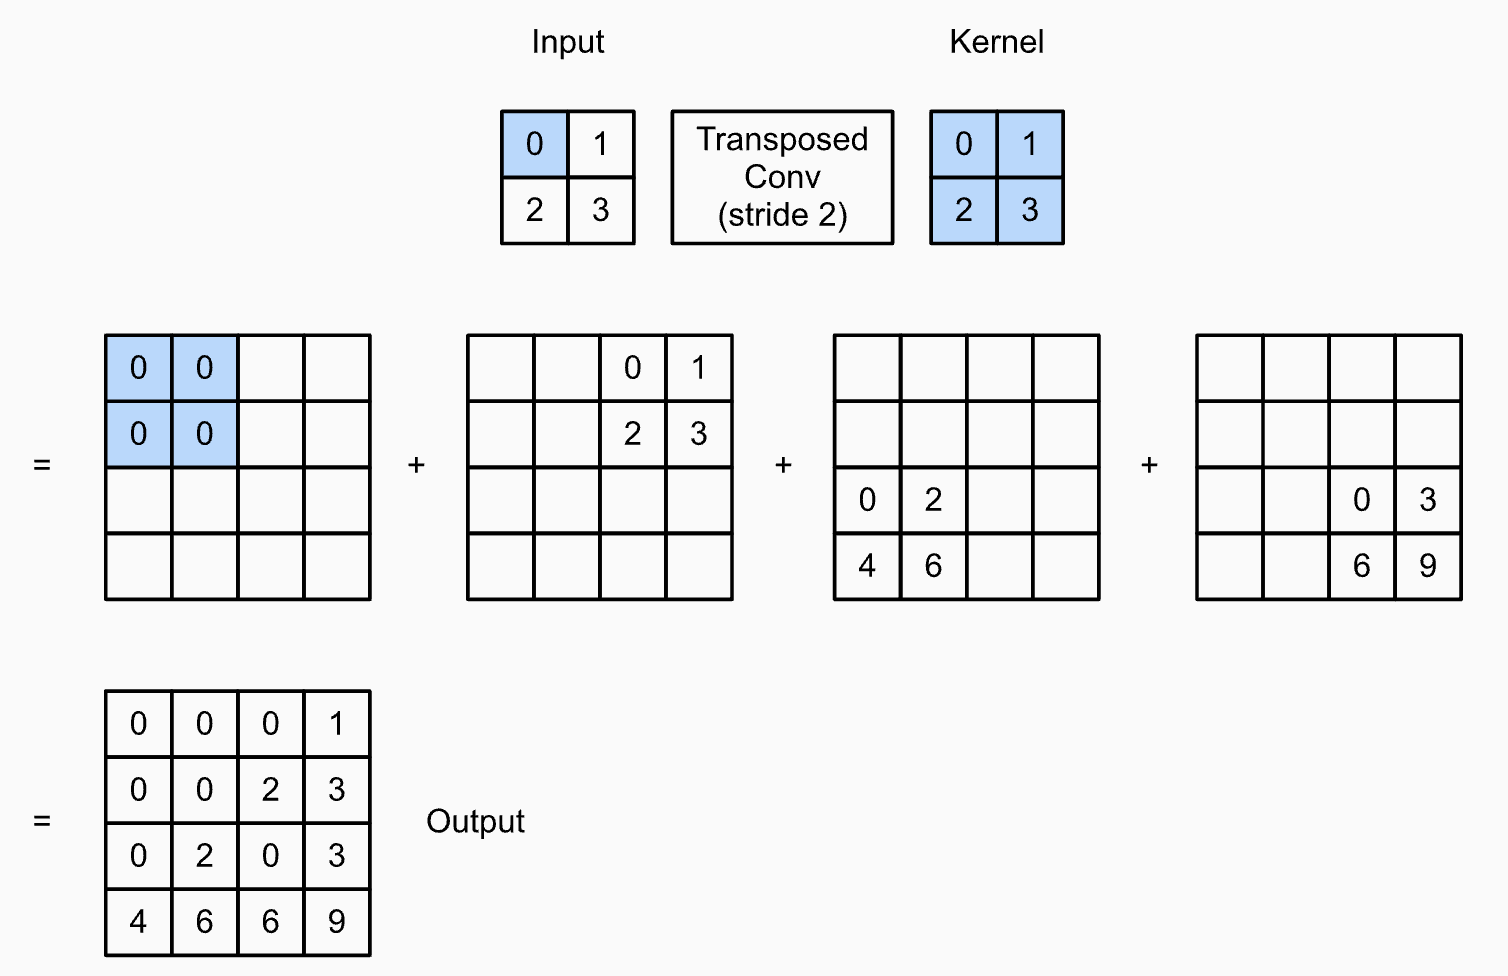

The architecture of your VAE network should be in the following form:


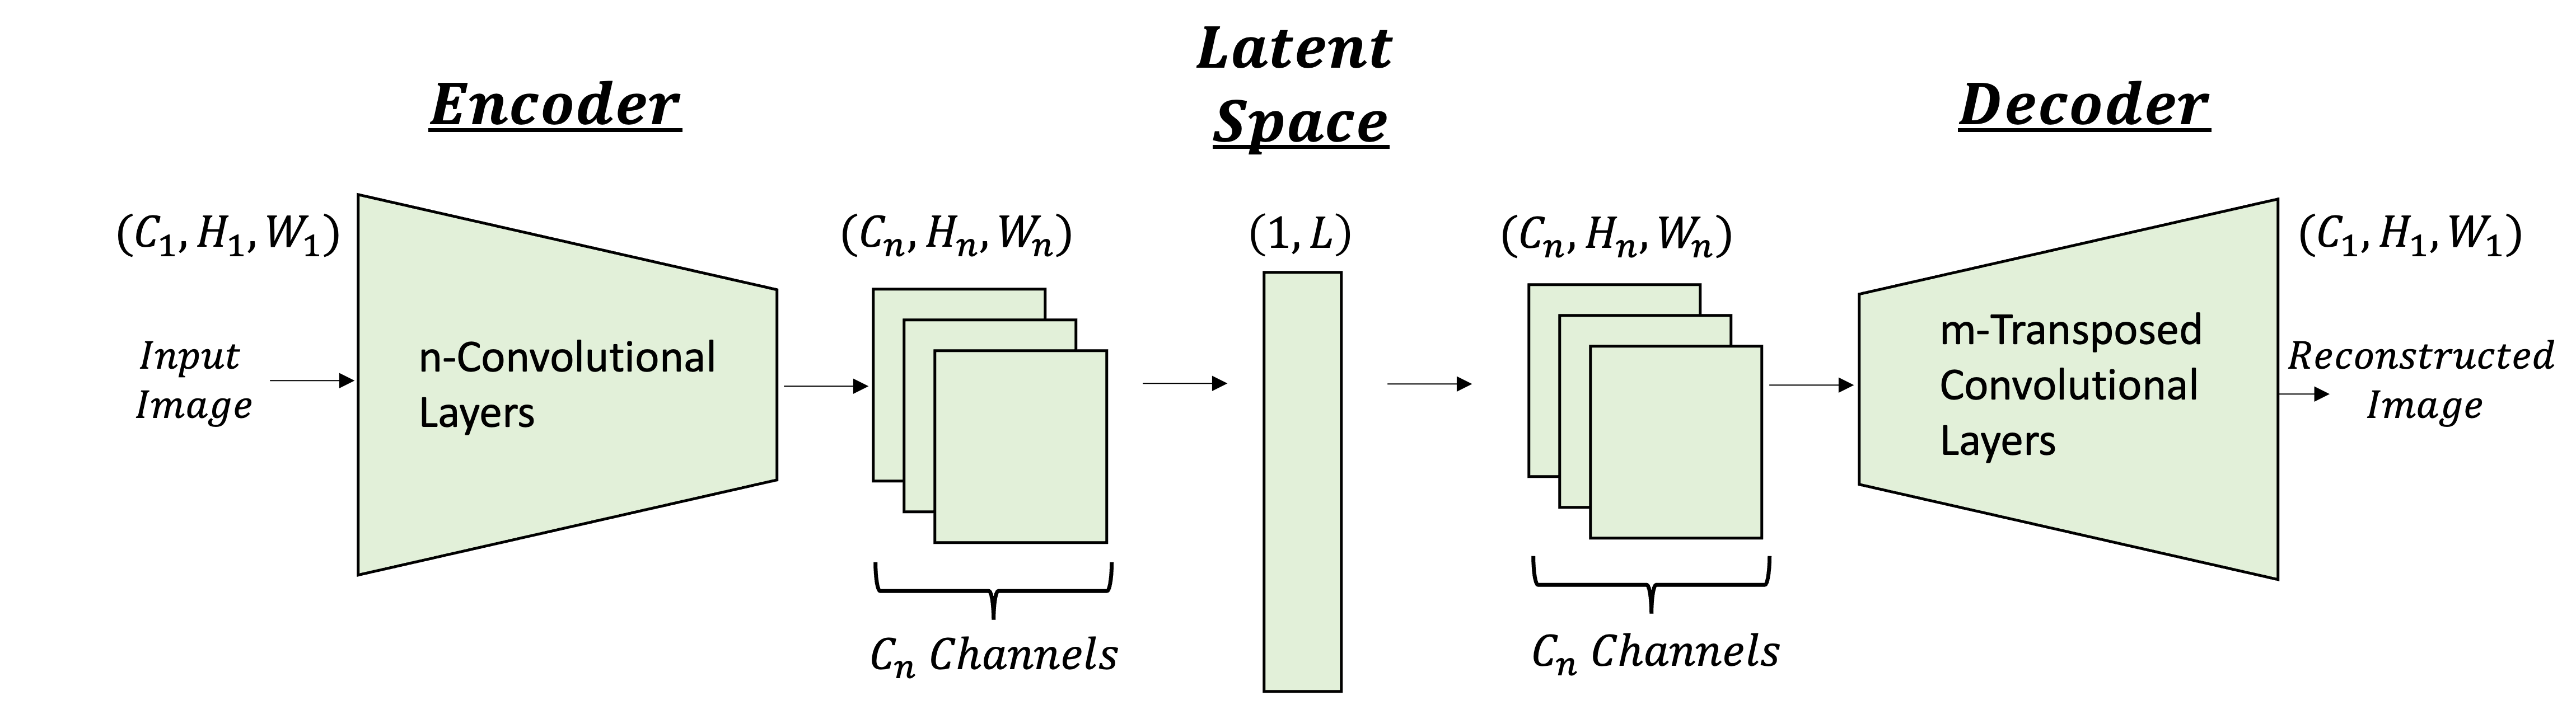

### Part (a) -- 7%

 **Encoder**

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(Batch\cdot H_4\cdot W_4\cdot C_4 , latent)$, where $(Batch$ is the batch size, $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent, input_shape=(3, image_h, image_w)):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Encoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 3
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.num_hiddens = num_hiddens
        self.latent = latent
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
#            nn.Conv2d(self.C, num_hiddens, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*2)
            nn.BatchNorm2d(num_hiddens*2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*4)
            nn.BatchNorm2d(num_hiddens*4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*8)
            nn.BatchNorm2d(num_hiddens*8),
            nn.ReLU()

        )
        self.flatten = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
      # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*num_hiddens channels
      # thus, Linear input shape: (8*num_hiddens)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))

        # n_linear_size = int(((image_h-3)/2 + 1)**2)
        print(f'fc1_inp: {fc1_inp}')
        self.fc_mu = nn.Linear(fc1_inp, latent)     # Insert the input size
        self.fc_logvar = nn.Linear(fc1_inp, latent) # Insert the input size

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'encoder forward: inputs.shape: {inputs.shape}')
        x = self.block1(inputs)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        #x.view(-1, image_h*image_w*3), self.num_hiddens, self.latent
        x = self.flatten(x)
        if DEBUG_NN:
          print(f'flatten(x): x.shape: {x.shape}')
#        x = self.relu(self.fc1(x))
#        z = self.fc1(x)
#        print(f'fc1(x): z.shape: {z.shape}')
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        if DEBUG_NN:
          print(f'encoder forward: fc_logvar(x): mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        return mu, logvar

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Part (b) -- 7%
 **Decoder**

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $Batch\cdot H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [10]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,latent, input_shape=(3, image_h, image_w)):
        super(Decoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Decoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 4
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.latent = latent
        self.num_hiddens = num_hiddens

        # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*n channels
        # thus, Linear input shape: (8*n)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))
        img_s = (self.H*self.W)//2**8

        self.fc_dec = nn.Linear(latent, fc1_inp) # Insert the output size

        self.block1 = nn.Sequential(
#            nn.ConvTranspose2d(fc1_inp // (self.H*self.W)/(2**8), num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            nn.ConvTranspose2d(fc1_inp // img_s, num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
#            nn.ConvTranspose2d(fc1_inp // (7*7), num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
#            nn.ConvTranspose2d(fc1_inp // (7*7), num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
#            nn.ConvTranspose2d(self.in_channels, num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride)),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 2),
            nn.LeakyReLU(0.1)
            )
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 4),
            nn.LeakyReLU(0.1)
            )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )

        self.block5 = nn.Sequential( # Add convolution layer and activation layer
            nn.Conv2d(num_hiddens // 8, 3, kernel_size=(3,3), stride=(1,1), padding=1),
            # Batch Normalization(num_hidden)
            nn.LeakyReLU(0.1)
            )

        self.flatten = torch.nn.Flatten()
        self.le_relu = torch.nn.LeakyReLU(0.1)
#        self.relu = torch.nn.ReLU()
#        self.logsoftmax = torch.nn.LogSoftmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'decoder forward: inputs.shape: {inputs.shape}')

        x = self.fc_dec(inputs)
        if DEBUG_NN:
          print(f'fc_dec(x): x.shape: {x.shape}')

#        H = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))
        H = int(self.H/(2**4))
        W = int(self.W/(2**4))
        C = int(8*self.num_hiddens)
        x = x.reshape(-1,C,H,W)
#        x = x.view(N,C,H,W)
        if DEBUG_NN:
          print(f'reshaped x: x.shape: {x.shape}')


        x = self.block1(x)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        x = self.block5(x)
        if DEBUG_NN:
          print(f'block5(x): x.shape: {x.shape}')

        #x.view(-1, image_h*image_w*3), self.num_hiddens, self.latent
#        x = self.flatten(x)
#        print(f'flatten(x): x.shape: {x.shape}')

        x_rec = self.sigmoid(x)
        if DEBUG_NN:
          print(f'decoder forward: sigmoid(x): x_rec.shape: {x_rec.shape}')

#        x = self.relu(self.fc1(x))
#        z = self.fc1(x)
#        print(f'fc1(x): z.shape: {z.shape}')
#        mu = self.fc_mu(x)
#        logvar = self.fc_logvar(x)
#        print(f'fc_logvar(x): mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')

        return x_rec

### Part (c) -- 4% 
**VAE Model**

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [11]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent, input_shape=(3, image_h, image_w)):
        super(VAE, self).__init__()
        self.num_hidden = dec_num_hidden
        self.latent = latent
        self.encode = Encoder(in_channels = enc_in_chnl, num_hiddens = enc_num_hidden,latent = latent, input_shape = input_shape)
        self.decode = Decoder(in_channels = dec_in_chnl, num_hiddens = dec_num_hidden,latent = latent, input_shape = input_shape)

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)     
      return eps.mul(std).add_(mu)

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'VAE forward: inputs.shape: {x.shape}')

#        mu_logvar = self.encoder(inputs.view(-1, image_h*image_w)).view(-1, 2,  self.latent)
#        mu, logvar = self.encode(x.view(-1, image_h*image_w*3)).view(-1, 2,  self.latent)
        mu, logvar = self.encode(x)
        if DEBUG_NN:
          print(f'VAE forward: mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        z = self.reparametrize(mu, logvar)
        if DEBUG_NN:
          print(f'z.shape: {z.shape}')

        x_rec = self.decode(z)
        if DEBUG_NN:
          print(f'VAE forward: x_rec.shape: {x_rec.shape}')

        return x_rec , mu, logvar


In [12]:
# Models basic test
#k = 20
#enc_in_chnl = 100
#enc_num_hidden = 120
#dec_in_chnl = 120
#dec_num_hidden = 130
#latent = 120
#model = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent)
#sample = model.encode(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent)
#mu, logvar = model.encode(training_data[:5])
#sample = model.decoder(z)
#y, mu, codes = train(model, train_loader, test_loader)

### Part (d) -- 7% 

**Loss Function**

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

# Write your explanation here
מטרת ההיפרפרמטר באטה בפונקציית ההפסד היא לשלוט על ההחלפה בין הפסד השחזור לבין שטיית הקאי אל בין האחורי המשוער של המקודד לקודם.
זה מאפשר שליטה רבה יותר על כמה המודל מעודד כדי להתאים את האחורי המשוער של המקודד הקודם.
כמובן שאם באטה שווה 1 אז בעצם אין שינוי וזה שווה לפונקציית ההפסד.
כאשר באטה שונה מ1 מעודדים את המודל להתאים את האחורי המשוער של המקודד לקודם בצורה חזקה יותר או פחות.
ערך גדול של באטה יעודד את המודל להתאים בצורה חזרה יותר בעוד שערך קטן מ1 יעודד את המודל לשים פחות דגש על היבט זה של ההפסד.
בחירת ערך מתאים עבור באטה יכול להיות גורם חשוב בכוונון הביצועים!


Here you should write specifically the code for the loss function.


In [13]:
beta = 0.1
def vae_loss(x_recon, x, mu, logvar):
# Reconstruction + KL divergence losses summed over all elements and batch
    if DEBUG_NN:
      print(f'vae_loss: x_recon.shape, x.shape: {x_recon.shape}, {x.shape}')
    MSE = nn.functional.mse_loss(
        x, x_recon, reduction='sum'
#        x_recon.view(-1), x.view(-1), reduction='sum'
#        x, x_recon, reduction='mean'
    )
    BCE = nn.functional.binary_cross_entropy(
#        x_recon, x.view(-1, 784), reduction='sum'
        x_recon, x, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
#    print(f'vae_loss: BCE, KLD: {BCE}, {KLD}, MSE: {MSE}')
    
#    return BCE + KLD*beta
    return MSE + KLD*beta


 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

In [14]:
## Not used
#learning_rate = 2e-3
#batch_size = 10
#num_epochs = 10
#dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.

#VAE Class inputs: 
#enc_in_chnl = 3
#enc_num_hidden = 32
#dec_in_chnl = 256
#dec_num_hidden = 512

In [15]:
#train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

## Question 5. VAE Training (15 %)



### Part (a) -- 4% 
Complete the training function below

In [16]:
## Not used
def train_orig(model, train_loader, test_loader, num_epochs,batch_size,dataset_size):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''
    
    # Your code goes Here:
    model.train()   
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(train_loader):
            imgs, _ = batch
            if torch.cuda.is_available():
                imgs = imgs.cuda()
          

                
            # Since the dataset is large, train on 'dataset_size' samples.
            if dataset_size//batch_size == batch_idx: 
                break


        # Validation set
        with torch.no_grad():
            model.eval()     
            for batch_idx, batch in enumerate(test_loader):
                img, _ = batch
                if torch.cuda.is_available():
                    img = img.cuda()

    return 

In [17]:
#def plot_learning_curve(iters, losses, epocs_vec, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg):
def plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(epocs_vec, train_losses, label="Train")
#    plt.xlabel("Iterations")
#    plt.ylabel("Loss")
#    plt.show()

#    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(epocs_vec, test_losses, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [18]:
def train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3, batch_size=10, dataset_size=64):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_iters, test_iters, train_losses, test_losses, epocs_vec = [], [], [], [], []
    codes = dict(μ=list(), logσ2=list(), label=list())
    model.train()
    n = 0 # total number of iterations
    nt = 0 # total number of test iterations
    img = None
    x_recon = None

    for epoch in range(num_epochs):
      train_loss = 0
      for batch_idx, batch in enumerate(train_loader):
        imgs, _ = batch
        if torch.cuda.is_available():
          imgs = imgs.cuda()
        if DEBUG:
          print(f'imgs.shape: {imgs.shape}')
        # reshape images

        # Since the dataset is large, train on 'dataset_size' samples.
        if dataset_size//batch_size == batch_idx: 
            break

        # reshape
        # N, H, W, C = imgs.shape
        # imgs = imgs.view(N,C,H,W)

        # ===================forward=====================
        x_recon, mu, logvar = model(imgs)
        loss = vae_loss(x_recon, imgs, mu, logvar)
        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        n += 1
        train_iters.append(n)

      # Testing - once per epoch
#      means, logvars, labels = list(), list(), list()
      means, logvars = list(), list()
      with torch.no_grad():
          model.eval()
          test_loss = 0
          for batch_idx, batch in enumerate(test_loader):
              img, label = batch
              if torch.cuda.is_available():
                  img = img.cuda()
              # Since the test dataset is large, train on 'dataset_size' samples.
              if dataset_size//batch_size == batch_idx: 
                  break
#            for img, label in test_loader:
              # ===================forward=====================
              x_recon, mu, logvar = model(img)
              test_loss += vae_loss(x_recon, img, mu, logvar).item()
              # =====================log=======================
              # save the current training information
              nt += 1
              test_iters.append(nt)

              means.append(mu.detach())
              logvars.append(logvar.detach())
              ## No labels
              #labels.append(label.detach())
          # ===================log========================
          codes['μ'].append(torch.cat(means))
          codes['logσ2'].append(torch.cat(logvars))
#          codes['label'].append(torch.cat(labels))
#          test_loss /= len(test_loader.dataset)
#          print(f'====> Test set loss: {test_loss:.4f}')
          #display_images(y, y_hat, 1, f'Epoch {epoch}')
          #display_images(img, x_recon, 1, f'Epoch {epoch}')


        # ===================log========================
#      print(f'====> Epoch: {epoch} Average loss: {train_loss / batch_size:.4f}')
      epocs_vec.append(epoch)
      test_loss = float(test_loss)/dataset_size
      train_loss = float(train_loss)/dataset_size
      test_losses.append(test_loss)  # compute *average* loss
      train_losses.append(train_loss)  # compute *average* loss
#      print(f"Epoch {epoch}, Train Iter {n}, Test Iter {nt}, {train_loss:.4f}, {test_loss:.4f}")
      print(f"Epoch {epoch}, Train Iter {n}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}")

#            if (checkpoint_path is not None) and n > 0:
#                torch.save(model.state_dict(), checkpoint_path.format(epoch))

    # return last img and x_recon
    return train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img
###########

#                print(f'====> Epoch: {epoch}, batch_idx: {batch_idx}, len(batch): {len(batch)} Average test loss: {test_loss / len(batch):.4f}')
                # The .detach() statements are added to make sure that no gradients are computed for these variables

    # return last batch
#    return imgs, mu, codes

### Part (b) -- 4%  

We first train with dimension of latent space $L=3$

We recommend to use *weight_init()* function, which helps stabilize the training process. 

In [19]:
## Not used
#latent1 = 3

#if torch.cuda.is_available():
#    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1).cuda()
#    model_1.weight_init(mean=0, std=0.02)
#else:
#    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
#    model_1.weight_init(mean=0, std=0.02)

#optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

Train your model, plot the train and the validation loss graphs. Explain what is seen.

Cuda available
Encoder: in_channels: 3, num_hiddens: 32, latent: 3, input_shape: (3, 64, 64)
fc1_inp: 4096
Decoder: in_channels: 32, num_hiddens: 256, latent: 3, input_shape: (3, 64, 64)
Epoch 0, Train Iter 12, train_loss: 1105.7715, test_loss: 1076.5276
Epoch 1, Train Iter 24, train_loss: 973.0307, test_loss: 763.0534


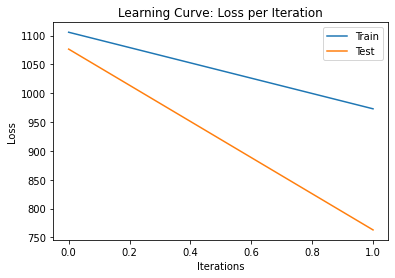

Sample images:
Recon of Sample images:


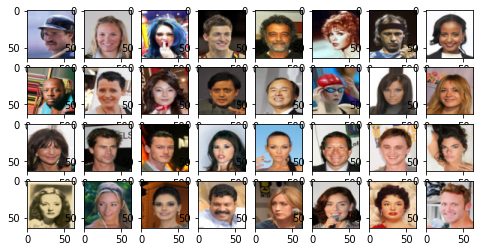

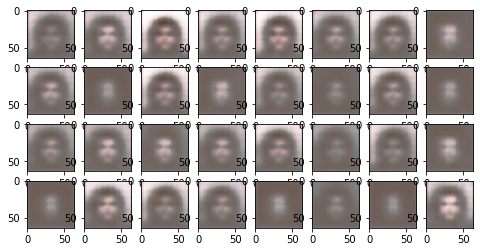

In [20]:
# Your Code Goes Here
DEBUG = False
DEBUG_NN = False

learning_rate = 2e-3
batch_size = 50
num_epochs = 2
#dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.
dataset_size = 600 # How many data samples to use for training, 30,000 should be enough.

#VAE Class inputs: 
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 32
dec_num_hidden = 256
latent = 3

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 


if torch.cuda.is_available():
    print(f'Cuda available')
    model = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent, input_shape=(3, image_h, image_w)).cuda()
#    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1).cuda()
    model.weight_init(mean=0, std=0.02)
else:
    print(f'Cuda is not available')
    model = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent, input_shape=(3, image_h, image_w))
#    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
    model.weight_init(mean=0, std=0.02)

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#y, mu, codes = train(model, train_loader, test_loader, num_epochs, learning_rate, batch_size, dataset_size)
train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train(
    model, train_loader, test_loader, num_epochs,
    learning_rate, batch_size, dataset_size)
plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)


#print(f'Sample images:')
#show(img.cpu())
#print(f'Recon of Sample images:')
#show(x_recon.cpu())

#print(f'Sample image:')
#plt.figure()
#plt.imshow(img[0].cpu())
#in_pic = in_.data.cpu().view(-1, 28, 28)
#print(f'Recon of Sample image:')
#plt.figure()
#plt.imshow(x_recon[0].cpu())

#learning_curve_info = train(model, train_loader, test_loader, num_epochs, learning_rate, batch_size, dataset_size)
#plot_learning_curve(*learning_curve_info)

#model = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent, input_shape=(3, 112, 112))

#model = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent)

#sample = model.encode(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent)
#mu, logvar = model.encode(training_data[:5])
#sample = model.decoder(z)
#y, mu, codes = train(model, train_loader, test_loader)
#train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3, batch_size=10, dataset_size=64)

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Explain.

in_pics.shape: torch.Size([50, 3, 64, 64])


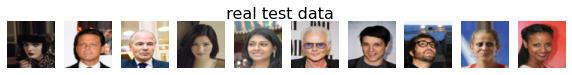

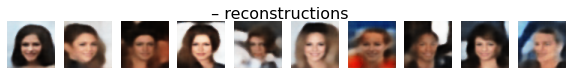

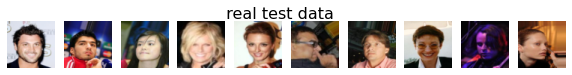

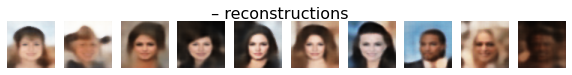

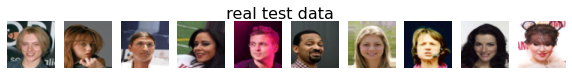

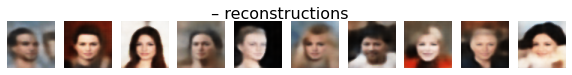

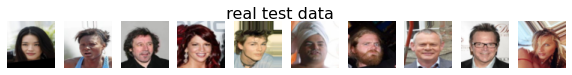

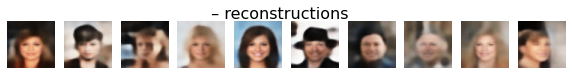

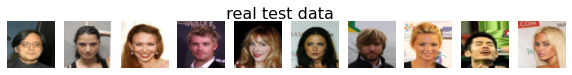

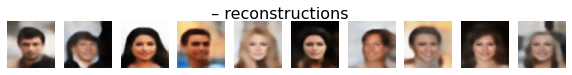

In [69]:
# Your Code Goes Here
def display_images(imgs, x_recon = None, X=1, label='', count=False):
    in_pics = imgs.data.cpu()
    if x_recon is not None:
      out_pics = x_recon.data.cpu()
#    print(f'in_pics.shape: {in_pics.shape}, out_pics.shape: {out_pics.shape}')
    print(f'in_pics.shape: {in_pics.shape}')
    Y = len(in_pics)//X
    for i in range(X):
      plt.figure(figsize=(10, 1.1))
      plt.suptitle(label + ' real test data', fontsize=16)
      for j in range(Y):
          plt.subplot(1,Y,j+1)
          in_pic = in_pics[j+Y*i].numpy().transpose((1, 2, 0))
          plt.imshow(in_pic)
          plt.axis('off')
      if x_recon is not None:
          plt.figure(figsize=(10, 1.1))
          plt.suptitle(label + ' – reconstructions', fontsize=16)
          for j in range(Y):
              plt.subplot(1,Y,j+1)
              out_pic = out_pics[j+Y*i].numpy().transpose((1, 2, 0))
              plt.imshow(out_pic)
              plt.axis('off')


#print(f'Sample images:')
#show(img.cpu())
#print(f'Recon of Sample images:')
#show(x_recon.cpu())

display_images(img, x_recon, X=5, label='', count=False)
#display_images(img, x_recon, n=1, label='None', count=False)

### Part (c) -- 7%  

Next, we train with larger $L > 3$

Based on the results for $L = 3$, choose a larger $L$ to improve your results.
Train new model with your choice for $L$.

In [54]:
DEBUG = False
DEBUG_NN = False

learning_rate = 2e-3
batch_size = 50
num_epochs = 20
#dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.
dataset_size = 6000 # How many data samples to use for training, 30,000 should be enough.

#VAE Class inputs: 
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 32
dec_num_hidden = 256
latent2 = 200

#train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 


if torch.cuda.is_available():
    print(f'Cuda available')
    model_2 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent2, input_shape=(3, image_h, image_w)).cuda()
#    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1).cuda()
    model_2.weight_init(mean=0, std=0.02)
else:
    print(f'Cuda is not available')
    model_2 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent2, input_shape=(3, image_h, image_w))
#    model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
    model_2.weight_init(mean=0, std=0.02)

train_iters, test_iters, train_losses, test_losses, epocs_vec, x_recon, img = train(
    model_2, train_loader, test_loader, num_epochs,
    learning_rate, batch_size, dataset_size)


Cuda available
Encoder: in_channels: 3, num_hiddens: 32, latent: 200, input_shape: (3, 64, 64)
fc1_inp: 4096
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (3, 64, 64)
Epoch 0, Train Iter 120, train_loss: 490.7813, test_loss: 297.9542
Epoch 1, Train Iter 240, train_loss: 322.9478, test_loss: 244.9818
Epoch 2, Train Iter 360, train_loss: 234.4662, test_loss: 216.7000
Epoch 3, Train Iter 480, train_loss: 204.5894, test_loss: 192.5003
Epoch 4, Train Iter 600, train_loss: 182.9783, test_loss: 173.7144
Epoch 5, Train Iter 720, train_loss: 173.0494, test_loss: 164.0512
Epoch 6, Train Iter 840, train_loss: 162.3107, test_loss: 157.8322
Epoch 7, Train Iter 960, train_loss: 155.3422, test_loss: 149.9722
Epoch 8, Train Iter 1080, train_loss: 151.1075, test_loss: 153.2667
Epoch 9, Train Iter 1200, train_loss: 143.5955, test_loss: 139.7206
Epoch 10, Train Iter 1320, train_loss: 139.2876, test_loss: 138.3334
Epoch 11, Train Iter 1440, train_loss: 135.7508, test_loss: 131.6848

Plot the train and the validation loss graphs. Explain what is seen.

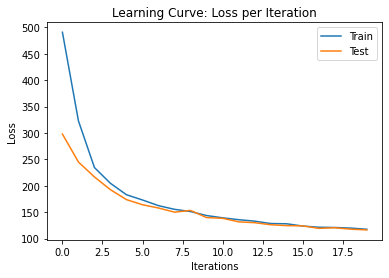

In [55]:
# Your Code Goes Here
plot_learning_curve(train_iters, test_iters, train_losses, test_losses, epocs_vec)

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Are the images identical? Explain.

in_pics.shape: torch.Size([50, 3, 64, 64]), out_pics.shape: torch.Size([50, 3, 64, 64])


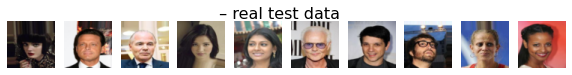

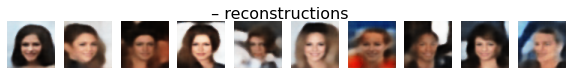

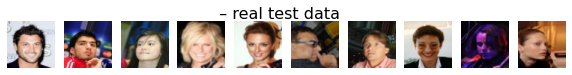

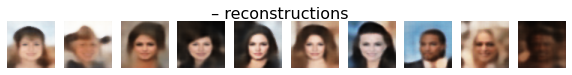

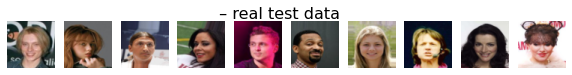

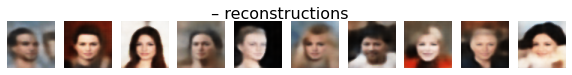

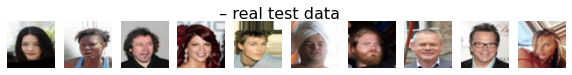

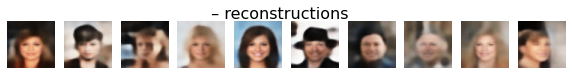

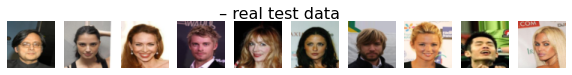

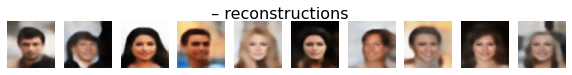

In [56]:
# Your Code Goes Here
display_images(img, x_recon, X=5, label='', count=False)


 What will happened if we choose extremely high dimension for the latent space?

# Write your explanation here
If you choose an extremely high dimension for the latent space in an generative models such as an Autoencoder or Variational Autoencoder, it can cause a few issues:
Overfitting: With a large latent space, the model has more capacity to fit to the training data, which can result in overfitting. This means that the model will perform well on the training data, but may not generalize well to new, unseen data.
Memory and computational cost: The more complex a model is, the more memory and computational resources it requires to train and run. This can make it difficult to work with large models.
High dimension also can lead to curse of dimensionality, which makes the optimization more difficult, and as result the model will converge very slowly.
Semantic meaning of the latent variables: When the latent space dimension is too high, it can be hard to interpret the semantic meaning of each latent variable.
Instead, it is better to keep the dimension of the latent space as low as possible while still maintaining the ability to reconstruct the original data accurately. This can be done by using techniques such as dimensionality reduction or feature selection, or by carefully designing the architecture of the model to have a smaller number of latent variables.

 
Did you output blurry reconstructed images? If the answer is yes, explain what could be the reason. If you got sharp edges and fine details, explain what you did in order to achieve that. 

Note: If you got blurry reconstructed images, just explain why. You dont need to change your code or retrain your model for better results (as long as your results can be interpreted as a human face).
 

# Write your explanation here
Some possible reasons include:
Insufficient data: If the training dataset is small or not diverse enough, the model may not be able to learn to reconstruct images with high accuracy.
Low resolution: If the original images used for training are low resolution, the model may not be able to reconstruct high-resolution images with sharp edges and fine details.
Model architecture: The architecture of the model (such as the number of layers and the type of layers used) can also impact the quality of the reconstructed images.
Hyperparameters: The specific settings used when training the model, such as the learning rate and batch size, can also affect the quality of the reconstructed images.
Training time: The number of training iteration and the data size also can be a factor to get blur images.
If you are training the model to reconstruct images with sharp edges and fine details, you may need to use a larger and more diverse training dataset, train with high-resolution images, use a more powerful model architecture, and experiment with different hyperparameter settings.

## Question 6: Generate New Faces (10 %)

Now, for the fun part!

We are going to generate new celebrity faces with our VAE models. A function for new faces generation is given to you. Modify it (if needed) to fit your code. 



sample.shape: torch.Size([50, 3, 64, 64])
in_pics.shape: torch.Size([50, 3, 64, 64])


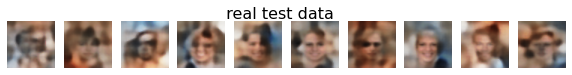

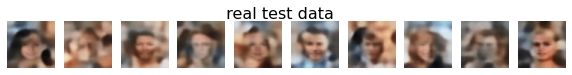

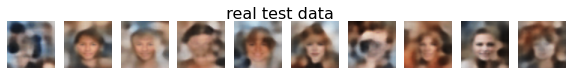

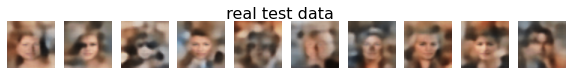

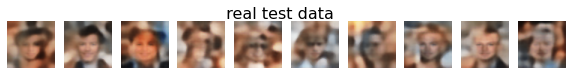

In [72]:
# creates random noise sample in the correct shape.
def generate_faces(model, grid_size, latent):
    model.eval()
    dummy = torch.empty([batch_size,latent])
    z = torch.randn_like(dummy).to(device)

    #insert the random noise to the decoder to create new samples.
    sample = model.decode(z)
    print(f'sample.shape: {sample.shape}')
    new_face_list = []

    j=0
    while j < grid_size: 
        new_face_list.append(sample[j])
        j+=1

    display_images(sample, X=5)

#    grid = make_grid(new_face_list)
#    print(f'grid.shape: {grid.shape}')
#    show(grid.cpu())

#latent2 = 200
generate_faces(model_2, grid_size=1, latent = latent2)

**Model 1 ($L = 3$) results:**

sample.shape: torch.Size([50, 3, 64, 64])
in_pics.shape: torch.Size([50, 3, 64, 64])


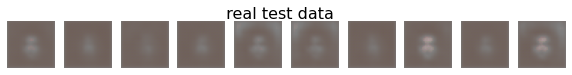

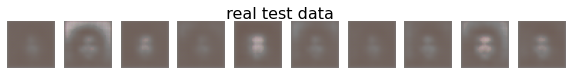

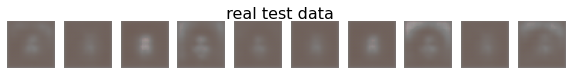

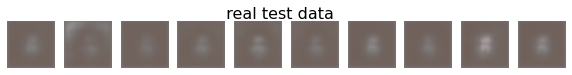

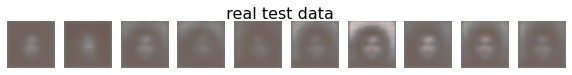

In [73]:
generate_faces(model,grid_size=32,latent=latent)

**Model 2 results:**

sample.shape: torch.Size([50, 3, 64, 64])
in_pics.shape: torch.Size([50, 3, 64, 64])


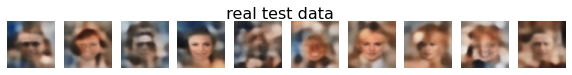

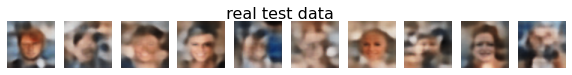

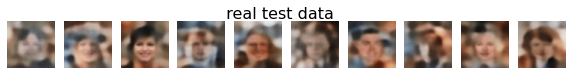

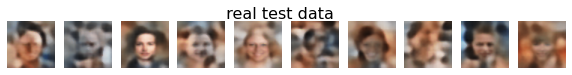

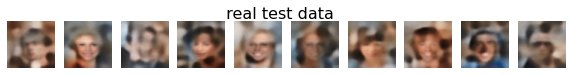

In [74]:
generate_faces(model_2,grid_size=32,latent=latent2)

*Q1:* Generate new faces with VAE model with latent space dimension = 3. Did you get diverse results? What are the most prominent features that the latent space capture? 

*Q2:* Generate new faces with VAE model with your decision for latent space dimension. What are the most prominent features that the latent space capture? 

*Q3:* What are the differences? Your results are similar to the dataset images? Do you get realistic images for your chosen latent space dimension? If not, change your decision or your network to acheive more realistic results.

#YOUR ANSWERS GOES HERE

# Q1 Answer: 

# Q2 Answer: 

# Q3 Answer: 

Q1: If you use a VAE model with a latent space dimension of 3, you may not get a diverse range of results. With such a low dimension, the model will have a limited capacity to represent the variability in the data. The most prominent features that the latent space might capture would be the overall shape of the face, such as the general outline of the jaw and cheekbones, as well as some rough variations in skin tone and facial expression.

Q2: If you choose a higher dimension for the latent space, such as 10 or more, you may get more diverse results, with the model able to capture more subtle variations in the data. The most prominent features that the latent space would capture in this case would depend on the dataset used to train the model. For example, if the dataset contains images of people with a wide range of facial expressions, skin tones, and hairstyles, the latent space might be able to represent these variations.

Q3: The main difference between the two scenarios is the degree of variability in the generated images, with higher dimensional latent spaces allowing for more diversity. The results generated from a VAE model will be similar to the dataset images in the sense that they will have the same general characteristics, such as being images of faces. However, the level of realism of the generated images will depend on the quality of the training dataset and the architecture of the model. If the model is unable to generate realistic images, you may need to adjust the model architecture or the training dataset to acheive better results.

## Question 7: Extrapolation (10 %)

Recall that we extrapolate in the images domain in Question 2, part (c).
Here, extrapolate in the latent space domain to generate new images.

Define $\beta = [0, 0.1, 0.2, ... , 0.9, 1]$ and randomly sample from $Z \sim \mathcal{N(0,1)}$ 2 different samples and generate 2 new face images: $X_1, X_2$.

Extrapolate in the latent domain as follows: $\beta_i\cdot Z_1 + (1-\beta_i)\cdot Z_2$ for each $\beta_i \in \beta$.

Plot the extrapolation of the images for each $\beta$ and discuss your results. 
Repeat the process for 3 different samples.



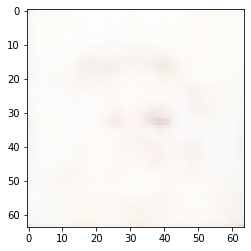

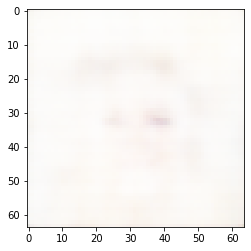

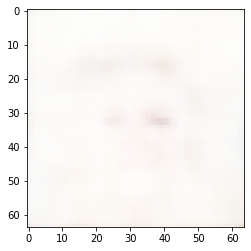

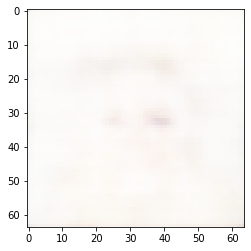

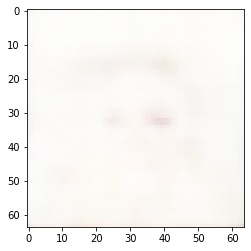

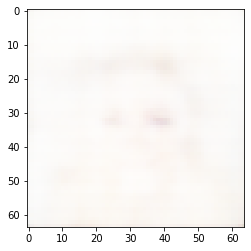

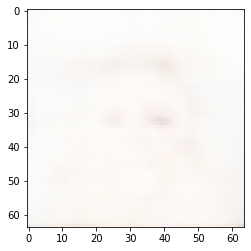

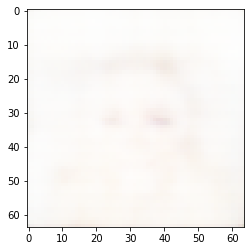

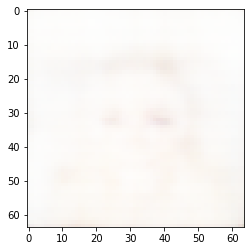

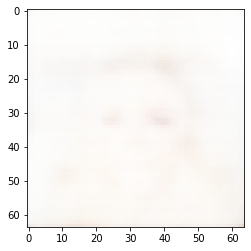

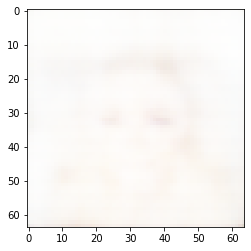

In [104]:
# TODO: img2 and loop on beta array
# YOUR CODE GOES HERE
beta = 0.5
β=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
idx = 3
idx = torch.randint(len(β), size=(1,)).item()

# Get image and latent
def get_img_latent():
  # Sample random image
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img1, _ = training_data[sample_idx]
  # add batch dimension
  imgs1 = torch.unsqueeze(img1, dim=0)
  imgs1[0]=1
  # Encode the image
  mu, logvar = model_2.encode(imgs1.cuda())
  # reparametrize to get latent 
  latent1 = model_2.reparametrize(mu, logvar)
  return img1, latent1

img1, latent1 = get_img_latent()
img2, latent2 = get_img_latent()

# extrapolate two latents
for beta in β:
  latent11 = beta*latent1 + (1-beta)*latent2
  # Reconstruct image from latent
  x_rec = model_2.decode(latent11)
  # show image
  img = x_rec.cpu().detach().numpy()
  img = img[0].transpose((1, 2, 0))
  plt.figure(clear=True)
  plt.imshow(img)


# Automatic PDF Generation and store in GDrive

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc > /dev/null 2>&1
!pip install pypandoc > /dev/null 2>&1

from google.colab import drive
drive.mount('/content/drive')
!cp 'drive/My Drive/Colab Notebooks/Assignment3_work.ipynb' ./

!jupyter nbconvert --to PDF "Assignment3_work.ipynb" > /dev/null 2>&1
!echo "pdf file generated"
#!ls -la
!cp './Assignment3_work.pdf' 'drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pdf file generated
